
#### **專案二**: 高解析度影像(SRCNN)分析



姓名：張子恩 
<hr>

 <font color=steelblue>**專案目標**</font>
  <br>
  
利用 PyTorch CNN 模型進行高解析度影像生成的訓練（SRCNN）。  
本次模型架構在輸出層前加入Drop out比率為0.3，以防止過度擬合，在匯入模型前已先訓練30次。

<hr>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_splitS
from sklearn.preprocessing import StandardScaler
import scipy.io
import torch
import glob as glob
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from srcnn import SRCNN
from PIL import Image
from utils import psnr
from torch.utils.data import DataLoader, Dataset
import torch
from srcnn import SRCNN
from PIL import Image
import math 

1.讀入 pre-trained 的 pth 檔，再進行 2 次 training，並展示其  Train PSNR 與 Val PSNR 值。

In [18]:
! python train.py --e 2 -w  ../outputs/model.pth

Computation device:  cuda
Loading weights to resume training...
SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout): Dropout(p=0.3, inplace=False)
)
Training samples: 22227
Validation samples: 19
Epoch 1 of 2
Train PSNR: 28.048
Val PSNR: 14.367
Saving model...
Epoch 2 of 2
Train PSNR: 29.245
Val PSNR: 14.361
Saving model...
Finished training in: 3.219 minutes


#### **討論**  
讀取先前練好的模型權重，再執行兩遍，其PSNR、Val PSNR值分別上升至28.893、14.492。

2.測試 Set5 與 Set14 並展示 Test PSNR on Set5 與 Test PSNR on Set14

In [19]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def validate(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(dataloader), total=len(dataloader)):
            image_data = data[0].to(device)
            label = data[1].to(device)
            outputs = model(image_data)
            # Calculate batch psnr (once every `batch_size` iterations).
            batch_psnr = psnr(label, outputs)
            running_psnr += batch_psnr

    final_loss = running_loss/len(dataloader.dataset)
    final_psnr = running_psnr/len(dataloader)
    return final_loss, final_psnr

# The SRCNN dataset module.
class SRCNNDataset(Dataset):
    def __init__(self, image_paths):
        self.all_image_paths = glob.glob(f"{image_paths}/*")

    def __len__(self):
        return (len(self.all_image_paths))

    def __getitem__(self, index):
        # The high resolution ground truth label.
        label = Image.open(self.all_image_paths[index]).convert('RGB')
        w, h = label.size[:]
        # Convert to 2x bicubic.
        low_res_img = label.resize((int(w*0.5), int(h*0.5)), Image.BICUBIC)
        # The low resolution input image.
        image = low_res_img.resize((w, h), Image.BICUBIC)

        # Uncomment the below code to visualize the image for sanity check.
        # plt.figure(figsize=(12, 9))
        # plt.subplot(1, 2, 1)
        # plt.imshow(image)
        # plt.axis('off')
        # plt.subplot(1, 2, 2)
        # plt.imshow(label)
        # plt.axis('off')
        # plt.show()

        image = np.array(image, dtype=np.float32)
        label = np.array(label, dtype=np.float32)

        image /= 255.
        label /= 255.

        image = image.transpose([2, 0, 1])
        label = label.transpose([2, 0, 1])

        return (
            torch.tensor(image, dtype=torch.float),
            torch.tensor(label, dtype=torch.float)
        )

# Prepare the datasets.
def get_datasets(
    image_paths
):
    dataset_test = SRCNNDataset(image_paths)
    return dataset_test

# Prepare the data loaders
def get_dataloaders(dataset_test):
    test_loader = DataLoader(
        dataset_test, 
        batch_size=1,
        shuffle=False
    )
    return test_loader


if __name__ == '__main__':
    # Load the model.
    model = SRCNN().to(device)
    model.load_state_dict(torch.load('../outputs/model.pth'))

    data_paths = [
        ['../input/Set5/original', 'Set5'],
        ['../input/Set14/original', 'Set14']
    ]

    for data_path in data_paths:
        dataset_test = get_datasets(data_path[0])
        test_loader = get_dataloaders(dataset_test)

        _, test_psnr = validate(model, test_loader, device)
        print(f"Test PSNR on {data_path[1]}: {test_psnr:.3f}")

100%|██████████| 5/5 [00:00<00:00, 21.38it/s]


Test PSNR on Set5: 24.447


100%|██████████| 14/14 [00:00<00:00, 45.90it/s]

Test PSNR on Set14: 22.637


#### **討論**  
丟入Set5、Set14的圖片後PSNR值分別為25、23。

3.實際對已訓練完成的 CNN 模型，輸入任何一張自己挑選的影像，將之放大 2 倍為高解度影像並且與 Bicubic 的結果對比。

<>:7: SyntaxWarning: invalid escape sequence '\i'
<>:7: SyntaxWarning: invalid escape sequence '\i'
C:\Users\USER\AppData\Local\Temp\ipykernel_17016\3027824507.py:7: SyntaxWarning: invalid escape sequence '\i'
  imgfile= "C:/vscode\淺度hw4/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\input/test_hr/dog.jpg"


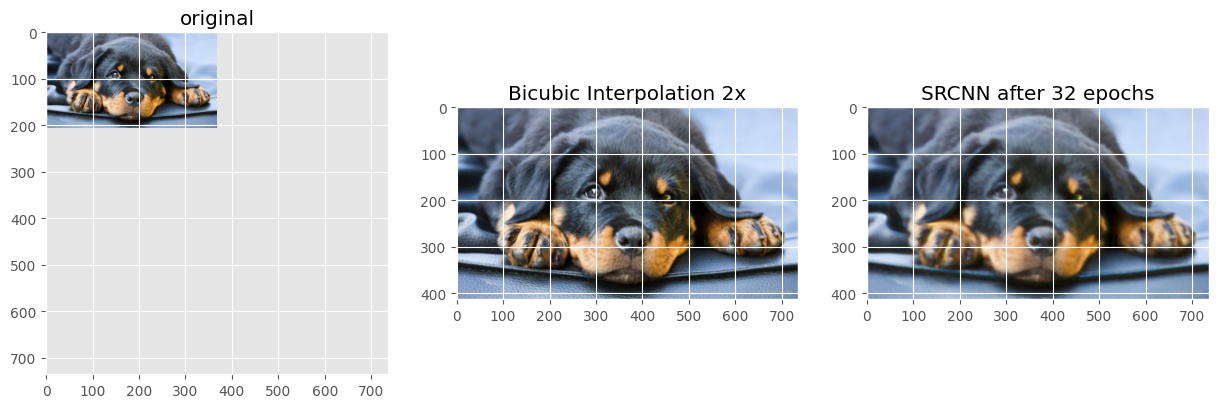

PSNR for SRCNN :25.76
PSNR for Bicubic :30.20


In [20]:

model = SRCNN()
checkpoint = torch.load("C:/vscode\淺度hw4/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution/outputs/model.pth")
model.load_state_dict(checkpoint)
model.eval()

scale= 2
imgfile= "C:/vscode\淺度hw4/20220606_SRCNN_Implementation_in_PyTorch_for_Image_Super_Resolution\input/test_hr/dog.jpg"
X_original = Image.open(imgfile)
[w,h]= X_original.size
X_low_res = X_original.resize((w//scale,h//scale),Image.Resampling.BICUBIC)

X_bicubic = X_low_res.resize((w,h),Image.Resampling.BICUBIC)

X_numpy = np.array(X_bicubic)
if X_numpy.max()>1:
    X_numpy = X_numpy/255
X_numpy = X_numpy.transpose([2,0,1])

X_tensor = torch.tensor(X_numpy , dtype = torch.float)
X_tensor = X_tensor.unsqueeze(0)
y_tensor = model(X_tensor)

hihg_res = y_tensor.cpu().detach().numpy().squeeze()
hihg_res = hihg_res.transpose([1,2,0])
hihg_res = np.clip(hihg_res,0,1)
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(X_low_res)
ax[0].set_title("original")
ax[0].set_xlim([0,w])
ax[0].set_ylim([w,0])
ax[1].imshow(X_bicubic)
ax[1].set_title(f"Bicubic Interpolation {scale}x")
ax[2].imshow(hihg_res)

ax[2].set_title("SRCNN after {} epochs".format(32))
plt.show()

diff = np.array(X_original)/255- hihg_res
rmse = math.sqrt(np.mean((diff)**2))
PSNR = 20*math.log10(hihg_res.max() / rmse)
print("PSNR for SRCNN :{:.2f}".format(PSNR))
diff = np.array(X_original)/255- np.array(X_bicubic)/255
rmse = math.sqrt(np.mean((diff)**2))
PSNR = 20*math.log10(hihg_res.max() / rmse)
print("PSNR for Bicubic :{:.2f}".format(PSNR))


#### **討論**  
經過32次訓練其表現有提升，但效果還不是很好，PSNR值從模糊化為30經過SRCNN後反而下降至25.76，可能原因是訓練太少次數。